<a href="https://colab.research.google.com/github/dj-dhillon/uno/blob/main/mnist_using_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from datetime import datetime 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# scaling images to the range [0,1]
transforms = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor()])

# downloading mnist dataset
train = datasets.MNIST(root='mnist_data',train=True,transform=transforms,download=True)
valid = datasets.MNIST(root='mnist_data',train=False,transform=transforms)

# creating the dataloaders
trainloader = DataLoader(dataset=train,batch_size=32,shuffle=True)
validloader = DataLoader(dataset=valid,batch_size=32,shuffle=False)

In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.layers = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5), stride=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5), stride=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5,5), stride=(1,1)),
            nn.ReLU()
        )
        self.classify = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )
    def forward(self, x):
        x = self.layers(x)
        x = torch.flatten(x,1)
        logits = self.classify(x)
        probs = F.softmax(logits,dim=1)
        return logits, probs

In [4]:
torch.manual_seed(42)
net = LeNet().to(device)
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)
loss = nn.CrossEntropyLoss()

In [5]:
def accuracy(net,dataloader,device):
    n = 0
    correct = 0 
    with torch.no_grad():
        net.eval()
        for X, ytrue in dataloader:
            ytrue = ytrue.to(device)
            X = X.to(device)
            _, yprob = net(X)
            _, predicted = torch.max(yprob, 1)
            n += ytrue.size(0)
            correct += (predicted == ytrue).sum()
    return correct.float() / n

In [6]:
def plotlosses(trainlosses,validlosses): 
    plt.style.use('seaborn')
    validlosses = np.array(validlosses)
    trainlosses = np.array(trainlosses) 
    fig, ax = plt.subplots(figsize = (9,5))
    ax.plot(trainlosses,color='red',label='Training loss') 
    ax.plot(validlosses,color='blue',label='Validation loss')
    ax.set(title="Loss over epochs",xlabel='Epoch',ylabel='Loss') 
    ax.legend()
    fig.show()
    plt.style.use('default')

In [7]:
def train(trainloader,net,loss,optimizer, device):
    net.train()
    runningloss = 0
    for X, ytrue in trainloader:
        optimizer.zero_grad()
        ytrue = ytrue.to(device)
        X = X.to(device)
        ## forward pass
        yhat, _ = net(X) 
        error = loss(yhat,ytrue) 
        runningloss += error.item() * X.size(0)
        ## backward pass
        error.backward()
        optimizer.step()
    epochloss = runningloss / len(trainloader.dataset)
    return net, optimizer, epochloss

In [8]:
def validate(validloader,net,loss, device):
    net.eval()
    runningloss = 0
    for X, ytrue in validloader:
        ytrue = ytrue.to(device)
        X = X.to(device)
        ### forward pass && record loss
        yhat, _ = net(X) 
        error = loss(yhat, ytrue) 
        runningloss += error.item() * X.size(0)
    epochloss = runningloss / len(validloader.dataset)
    return net, epochloss

In [9]:
def training(net,loss, optimizer, trainloader, validloader, epochs, device, printevery=1):
    bestloss = 1e9
    trainlosses = []
    validlosses = []
    for epoch in range(0, epochs):
        ### training
        net, optimizer, trainloss = train(trainloader, net,loss, optimizer, device)
        trainlosses.append(trainloss)
        ### validation
        with torch.no_grad():
            net, validloss = validate(validloader,net,loss, device)
            validlosses.append(validloss)
        if epoch % printevery == (printevery-1):
            trainacc = accuracy(net,trainloader,device=device)
            validacc = accuracy(net,validloader,device=device)
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'No. of Epochs : {epoch}\t'
                  f'Training loss: {trainloss:.4f}\t'
                  f'Validation loss: {validloss:.4f}\t'
                  f'Training accuracy: {100 * trainacc:.2f}\t'
                  f'Validation accuracy: {100 * validacc:.2f}')
    plotlosses(trainlosses, validlosses)
    return net, optimizer, (trainlosses, validlosses)

10:53:56 --- No. of Epochs : 0	Training loss: 0.2078	Validation loss: 0.0739	Training accuracy: 97.64	Validation accuracy: 97.66
10:54:47 --- No. of Epochs : 1	Training loss: 0.0648	Validation loss: 0.0449	Training accuracy: 98.66	Validation accuracy: 98.61
10:55:39 --- No. of Epochs : 2	Training loss: 0.0469	Validation loss: 0.0392	Training accuracy: 98.97	Validation accuracy: 98.77
10:56:30 --- No. of Epochs : 3	Training loss: 0.0368	Validation loss: 0.0416	Training accuracy: 98.94	Validation accuracy: 98.58
10:57:21 --- No. of Epochs : 4	Training loss: 0.0319	Validation loss: 0.0285	Training accuracy: 99.42	Validation accuracy: 99.01
10:58:11 --- No. of Epochs : 5	Training loss: 0.0248	Validation loss: 0.0295	Training accuracy: 99.38	Validation accuracy: 99.06
10:59:02 --- No. of Epochs : 6	Training loss: 0.0219	Validation loss: 0.0327	Training accuracy: 99.58	Validation accuracy: 99.01
10:59:53 --- No. of Epochs : 7	Training loss: 0.0178	Validation loss: 0.0304	Training accuracy: 9

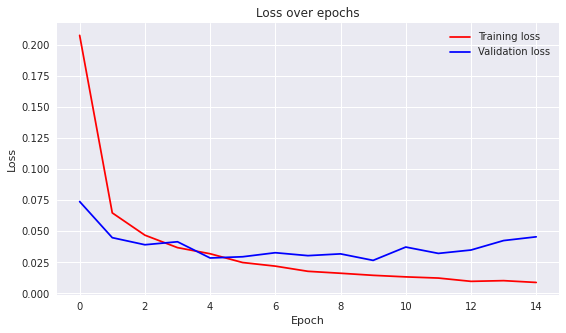

In [10]:
n_epochs = 15
net, optimizer, _ = training(net,loss, optimizer, trainloader, validloader, n_epochs,device)

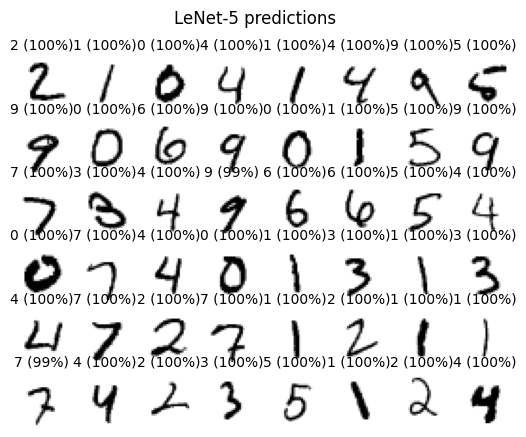

In [11]:
num_rows = 6
row_img = 8
fig = plt.figure()
for index in range(1, row_img * num_rows + 1):
    plt.subplot(num_rows,row_img,index)
    plt.imshow(valid.data[index], cmap='gray_r')
    plt.axis('off')
    with torch.no_grad():
        net.eval()
        _, probs = net(valid[index][0].unsqueeze(0))
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    plt.title(title, fontsize=10)
fig.suptitle('LeNet-5 predictions');